# 03 Descriptive Statistics

**Goal:** Produce reproducible summary statistics and visualizations for:
- MIT (risk domains, intent, entity, timing)
- GMF (goal, technology, technical failures)
- CSET (harm basis, sector of deployment, etc. where present)
- Report corpus (source domains, languages, tags if usable)

All figures are saved to `../outputs/figures/`.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

DATA = Path("../data")
OUT = Path("../outputs/figures")
OUT.mkdir(parents=True, exist_ok=True)

# ---------- Load incidents (small) ----------
inc = pd.read_csv(DATA / "incidents.csv")

# ---------- Load reports (ONLY columns we need for plots) ----------
# reports.csv can be heavy because "text" can be very large; avoid loading it.
rep_cols_needed = ["url", "source_domain", "language", "tags",
                   "date_published", "date_submitted", "date_modified", "date_downloaded"]
rep = pd.read_csv(DATA / "reports.csv", usecols=lambda c: c.strip().lower() in rep_cols_needed)

# ---------- Load taxonomies ----------
mit = pd.read_csv(DATA / "classifications_MIT.csv") if (DATA / "classifications_MIT.csv").exists() else None
gmf = pd.read_csv(DATA / "classifications_GMF.csv") if (DATA / "classifications_GMF.csv").exists() else None
cset = pd.read_csv(DATA / "classifications_CSETv1.csv") if (DATA / "classifications_CSETv1.csv").exists() else None

# ---------- Normalize columns ----------
inc.columns = [c.strip().lower() for c in inc.columns]
rep.columns = [c.strip().lower() for c in rep.columns]
if mit is not None: mit.columns = [c.strip().lower() for c in mit.columns]
if gmf is not None: gmf.columns = [c.strip().lower() for c in gmf.columns]
if cset is not None: cset.columns = [c.strip().lower() for c in cset.columns]

# ---------- Normalize incident id naming across taxonomies ----------
def normalize_incident_id(df):
    if df is None:
        return None
    if "incident id" in df.columns and "incident_id" not in df.columns:
        df = df.rename(columns={"incident id": "incident_id"})
    return df

mit = normalize_incident_id(mit)
gmf = normalize_incident_id(gmf)
cset = normalize_incident_id(cset)

# ---------- Plot helpers ----------
def savefig(fig, name):
    fig.savefig(OUT / name, bbox_inches="tight", dpi=200)

def barh_top(series, title, xlabel, fname, topn=15):
    vc = series.dropna().astype(str).value_counts().head(topn).sort_values()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vc.plot(kind="barh", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    savefig(fig, fname)
    plt.show()
    return vc

def barh_percent(series, title, fname):
    pct = (series.dropna().astype(str).value_counts(normalize=True) * 100).round(1).sort_values()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pct.plot(kind="barh", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Percent")
    savefig(fig, fname)
    plt.show()
    return pct

print("Incidents:", inc.shape)
print("Reports (selected cols):", rep.shape, "cols:", rep.columns.tolist())
print("MIT:", None if mit is None else mit.shape)
print("GMF:", None if gmf is None else gmf.shape)
print("CSET:", None if cset is None else cset.shape)

Incidents: (1367, 9)
Reports (selected cols): (6687, 8) cols: ['date_downloaded', 'date_modified', 'date_published', 'date_submitted', 'language', 'source_domain', 'url', 'tags']
MIT: (1242, 8)
GMF: (326, 21)
CSET: (214, 65)


MIT missing column: risk_domain


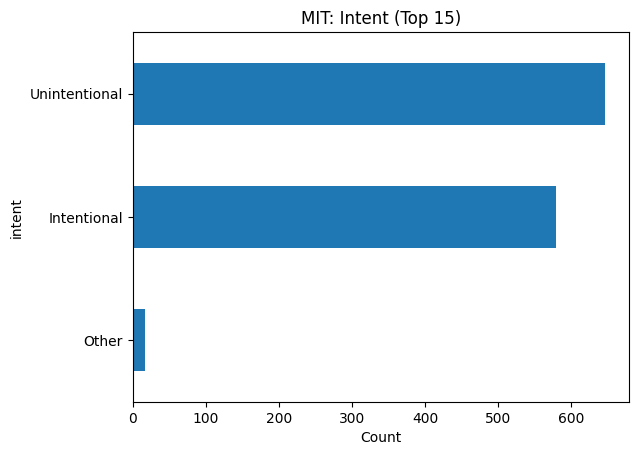

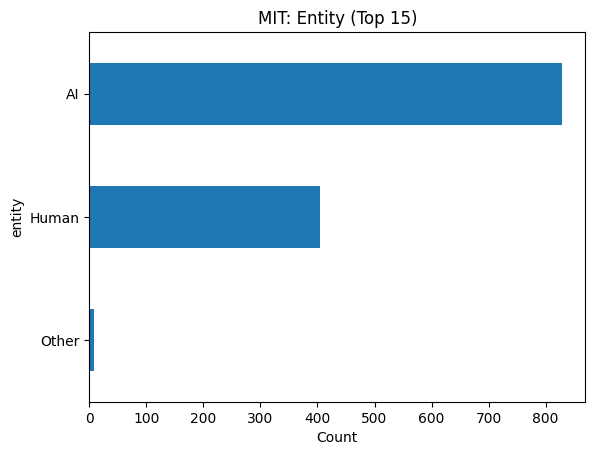

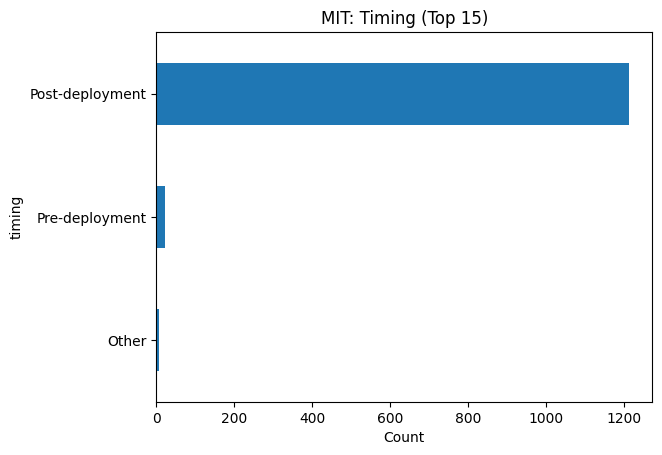

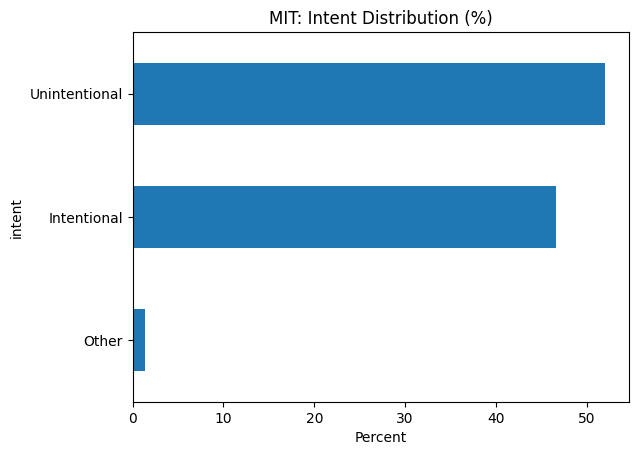

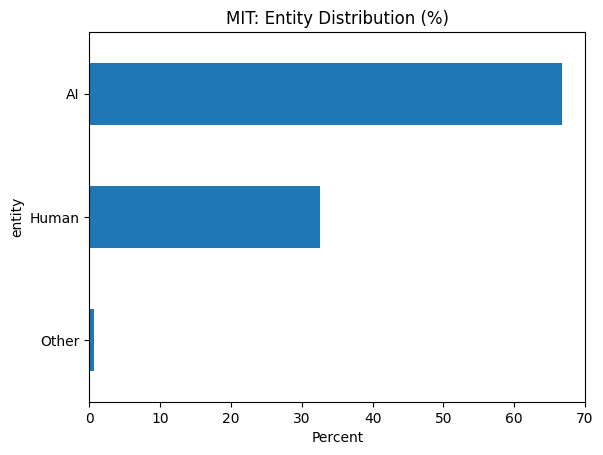

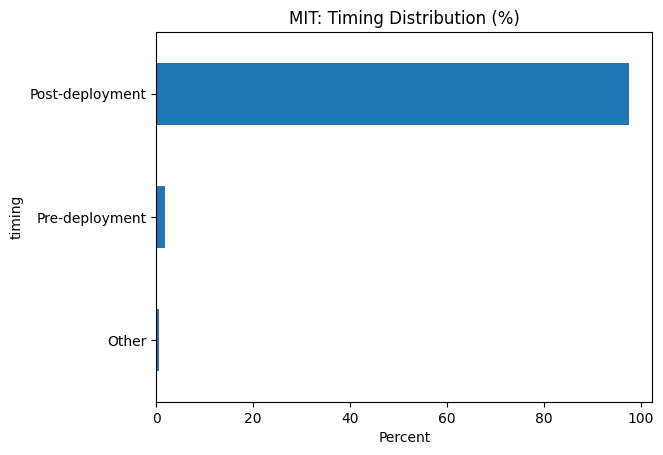

In [2]:
if mit is None:
    print("MIT classifications not found.")
else:
    for col, fname in [
        ("risk_domain", "20_mit_risk_domain_top15.png"),
        ("intent", "21_mit_intent_top15.png"),
        ("entity", "22_mit_entity_top15.png"),
        ("timing", "23_mit_timing_top15.png"),
    ]:
        if col in mit.columns:
            barh_top(
                mit[col],
                title=f"MIT: {col.replace('_',' ').title()} (Top 15)",
                xlabel="Count",
                fname=fname,
                topn=15
            )
        else:
            print("MIT missing column:", col)

if mit is not None:
    for col, fname in [
        ("intent", "24_mit_intent_percent.png"),
        ("entity", "25_mit_entity_percent.png"),
        ("timing", "26_mit_timing_percent.png"),
    ]:
        if col in mit.columns:
            barh_percent(mit[col], f"MIT: {col.title()} Distribution (%)", fname)

In [3]:
if mit is not None and "risk_domain" in mit.columns:
    top_domains = mit["risk_domain"].dropna().astype(str).value_counts().head(12).index

    if "intent" in mit.columns:
        df = mit.dropna(subset=["risk_domain", "intent"]).copy()
        df["risk_domain"] = df["risk_domain"].astype(str)
        df["intent"] = df["intent"].astype(str)
        df = df[df["risk_domain"].isin(top_domains)]

        ct = pd.crosstab(df["risk_domain"], df["intent"], normalize="index")
        ct_pct = (ct * 100).round(1)
        print("MIT: Risk Domain × Intent (% within domain)")
        display(ct_pct)

    if "entity" in mit.columns:
        df = mit.dropna(subset=["risk_domain", "entity"]).copy()
        df["risk_domain"] = df["risk_domain"].astype(str)
        df["entity"] = df["entity"].astype(str)
        df = df[df["risk_domain"].isin(top_domains)]

        ct2 = pd.crosstab(df["risk_domain"], df["entity"], normalize="index")
        ct2_pct = (ct2 * 100).round(1)
        print("MIT: Risk Domain × Entity (% within domain)")
        display(ct2_pct)
else:
    print("MIT risk_domain not found; skipping cross-tabs.")

MIT risk_domain not found; skipping cross-tabs.


Chosen GMF goal column: known ai goal
Chosen GMF tech column: known ai technology snippets
Chosen GMF failure column: known ai technical failure snippets


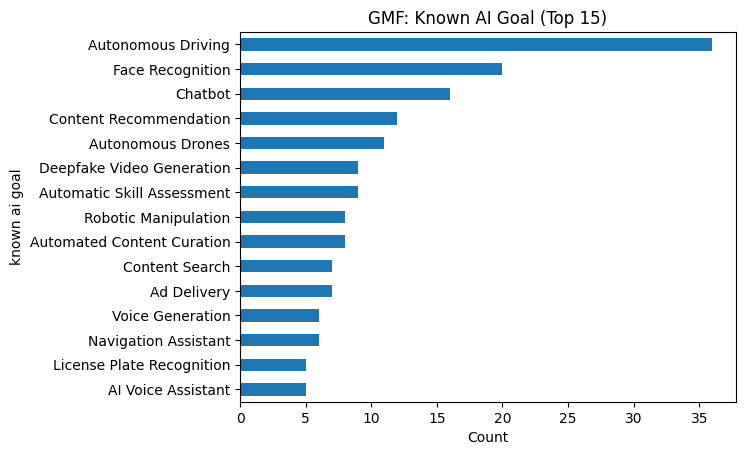

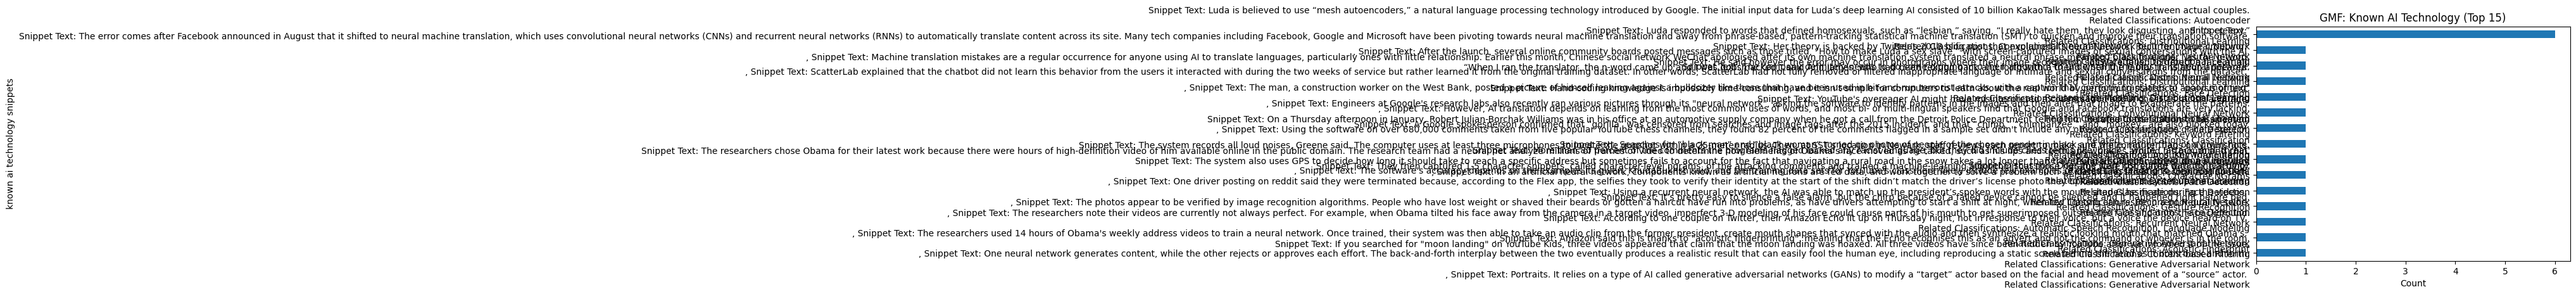

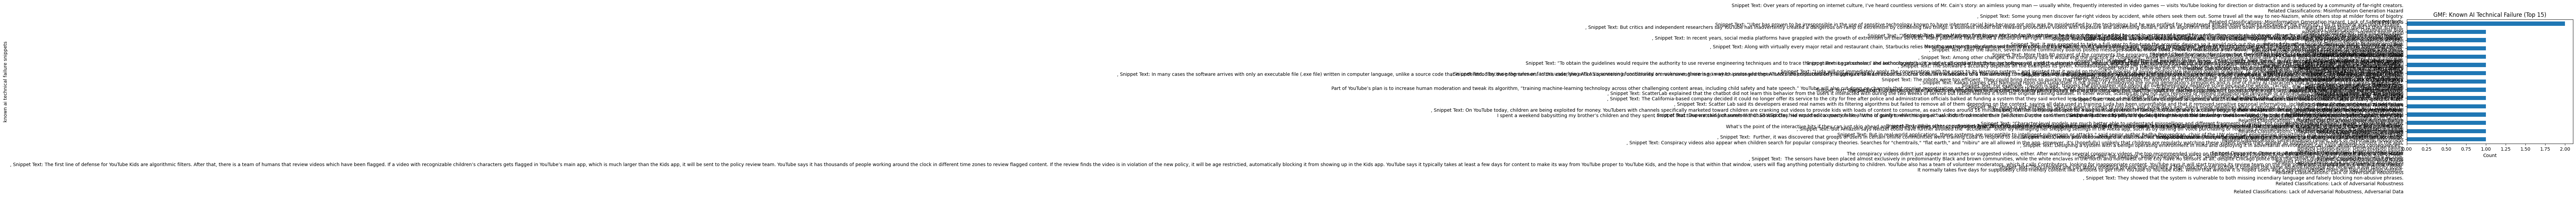

In [4]:
if gmf is None:
    print("GMF classifications not found.")
else:
    def pick_col_by_keywords(df, must_have_keywords, nice_to_have=None):
        nice_to_have = nice_to_have or []
        candidates = []
        for c in df.columns:
            cl = c.lower()
            if all(k in cl for k in must_have_keywords):
                score = sum(1 for k in nice_to_have if k in cl)
                non_null = df[c].notna().sum()
                candidates.append((score, non_null, c))
        if not candidates:
            return None
        return sorted(candidates, reverse=True)[0][2]

    goal_col = pick_col_by_keywords(gmf, ["goal"], nice_to_have=["known", "ai"])
    tech_col = pick_col_by_keywords(gmf, ["technology"], nice_to_have=["known", "ai"])
    fail_col = pick_col_by_keywords(gmf, ["failure"], nice_to_have=["technical", "known", "ai"])

    print("Chosen GMF goal column:", goal_col)
    print("Chosen GMF tech column:", tech_col)
    print("Chosen GMF failure column:", fail_col)

    if goal_col:
        barh_top(gmf[goal_col], "GMF: Known AI Goal (Top 15)", "Count", "40_gmf_goal_top15.png", 15)
    if tech_col:
        barh_top(gmf[tech_col], "GMF: Known AI Technology (Top 15)", "Count", "41_gmf_tech_top15.png", 15)
    if fail_col:
        barh_top(gmf[fail_col], "GMF: Known AI Technical Failure (Top 15)", "Count", "42_gmf_failure_top15.png", 15)

In [5]:
if cset is None:
    print("CSET classifications not found.")
else:
    # Try a few likely CSET columns; plot only if present
    candidates = [
        "harm_distribution_basis",
        "sector_of_deployment",
        "harm basis",
        "sector",
        "protected_class",
        "basis",
    ]

    found_any = False
    for col in candidates:
        if col in cset.columns:
            found_any = True
            barh_top(
                cset[col],
                title=f"CSET: {col.replace('_',' ').title()} (Top 15)",
                xlabel="Count",
                fname=f"30_cset_{col}_top15.png",
                topn=15
            )

    if not found_any:
        print("No expected CSET columns found in candidates list.")
        print("CSET columns:", cset.columns.tolist())

No expected CSET columns found in candidates list.
CSET columns: ['namespace', 'incident_id', 'published', 'incident number', 'annotator', 'annotation status', 'peer reviewer', 'quality control', 'physical objects', 'entertainment industry', 'report, test, or study of data', 'deployed', 'producer test in controlled conditions', 'producer test in operational conditions', 'user test in controlled conditions', 'user test in operational conditions', 'harm domain', 'tangible harm', 'ai system', 'clear link to technology', 'there is a potentially identifiable specific entity that experienced the harm', 'ai harm level', 'ai tangible harm level notes', 'impact on critical services', 'rights violation', 'involving minor', 'detrimental content', 'protected characteristic', 'harm distribution basis', 'notes (special interest intangible harm)', 'special interest intangible harm', 'ai system.1', 'clear link to technology', 'harmed class of entities', 'annotator’s ai special interest intangible harm

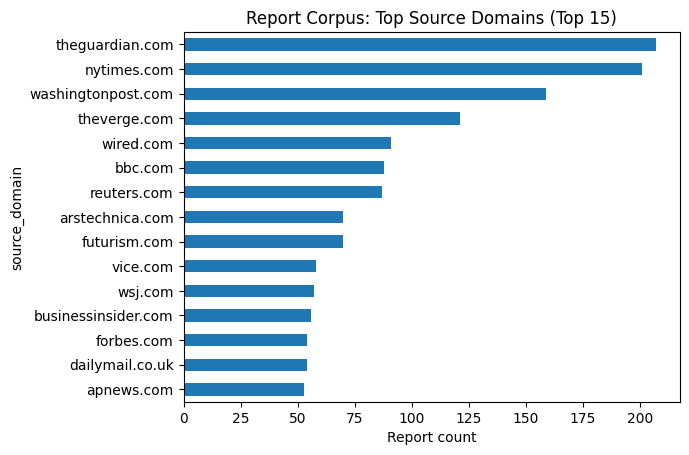

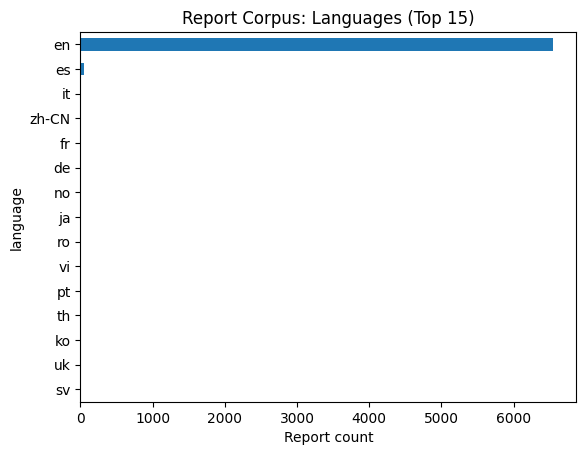

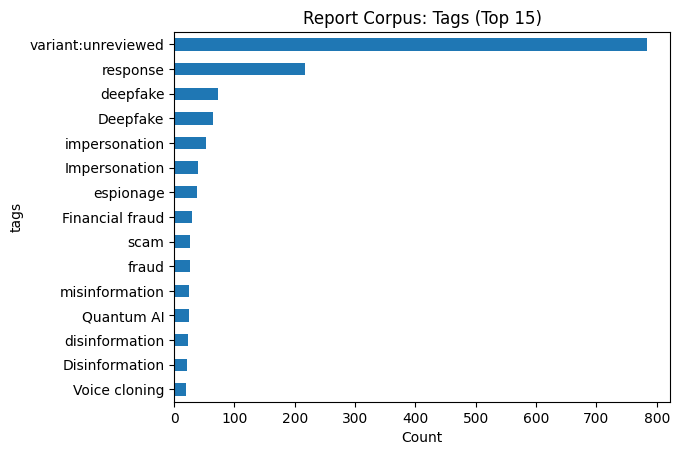

In [6]:
# Source domain concentration
if "source_domain" in rep.columns:
    barh_top(rep["source_domain"], "Report Corpus: Top Source Domains (Top 15)", "Report count",
             "50_reports_top_source_domains.png", 15)

# Language distribution
if "language" in rep.columns:
    barh_top(rep["language"], "Report Corpus: Languages (Top 15)", "Report count",
             "51_reports_languages.png", 15)

# Tags: only if tags column exists
if "tags" in rep.columns:
    tags_series = rep["tags"].dropna().astype(str)

    # If tags look too long / not tag-like, skip exploding to avoid huge runtime
    if tags_series.str.len().median() > 200:
        print("Tags appear text-heavy (median length > 200). Skipping explode-based tag analysis.")
    else:
        exploded = tags_series.str.split(",").explode().str.strip()
        barh_top(exploded, "Report Corpus: Tags (Top 15)", "Count",
                 "52_reports_tags.png", 15)

## Interpretation & Limitations

- These descriptive statistics reflect **documented** incidents and reports in the snapshot, not the full universe of AI harms.
- Taxonomy coverage differs (MIT > GMF/CSET), so deeper classifications may not represent all incidents equally.
- Report corpus concentration can reflect monitoring/editorial bias as well as incident prevalence.

These outputs are designed for transparent, reproducible exploration and responsible interpretation.